In [52]:
import gudhi as gd
import gudhi.representations.vector_methods as grvm

import wfdb 
from wfdb import processing
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

import scipy as scp

In [2]:
def quasi_attractorize(series, step):
    n = series.shape[0]

    z = []
    for i in range(n - step + 1):
        z.append(series[i:i + step].reshape(1, step)[0])

    return np.array(z)

In [3]:
def plot_attractor(attractor):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.scatter(xs=attractor[:, 0],
            ys=attractor[:, 1],
            zs=attractor[:, 2])
    plt.title(f'{len(attractor)}')
    plt.show()

In [4]:
# wfdb.show_ann_labels()

In [5]:
beat_annotations = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?']

non_beat_annotations = ['[', '!', ']', 'x', '(', ')', 'p', 't', 'u', '`', "'", '^', '|', '~', 's', 'T', '*', 'D', '=', '"', '@']
ignore_annotations = ['Q', '?']

classes_mapping = {
    'N': 0,
    '/': 0,
    'f': 0,
    'F': 1,
    'L': 1, 
    'R': 1,
    'B': 1,
    'A': 1,
    'a': 1, 
    'J': 1,
    'S': 1,
    'V': 1,
    'r': 1,
    'e': 1,
    'j': 1,
    'n': 1,
    'E': 1, 
    'Q': -1,
    '?': -1
}

In [7]:
def extract_attractors(signal, annotations, event_indexes, step):
    n = event_indexes.shape[0]

    attractors = []
    attractor_annotations = []
    for i in range(n - step + 1):
        idx1 = event_indexes[i]
        idx2 = event_indexes[i+step-1] + 1 
        
        extracted_signal = signal[idx1:idx2]
        
        attractor = quasi_attractorize(extracted_signal, step=3)

        ann = 1 if 1 in annotations[i:i+step] else 0

        attractors.append(attractor)
        attractor_annotations.append(ann)

    return attractors, attractor_annotations

In [8]:
def get_persistence_diagram(points, plot=False):
    gudhi_complex = gudhi.RipsComplex(points=points)
    # gudhi_complex = gudhi.AlphaComplex(points=signal)
    simplex_tree = gudhi_complex.create_simplex_tree(max_dimension=2)

    diag = simplex_tree.persistence()
    if plot:
        gudhi.plot_persistence_diagram(diag, legend=True)
    
    return diag

In [9]:
def filter_signal(signal, cutoff_freqs, fs, numtaps):
    filter_taps = scp.signal.firwin(numtaps=numtaps, fs=fs, cutoff=cutoff_freqs)
    return scp.signal.lfilter(filter_taps, 1.0, x=signal)

In [10]:
def extract_numpy_from_diag(diagram):
    tuples = [x[1] for x in diagram]
    xs = np.array([d[0] for d in tuples])
    ys = np.array([d[1] for d in tuples])

    return np.array([xs, ys]).T

In [15]:
def preprocess(record, annotation, new_fs, numtaps, cutoff_freqs):
    # Resampling to 200 Hz
    zero_channel_signal, resampled_ann = processing.resample_singlechan(record.p_signal[:, 0], annotation, record.fs, new_fs)

    # FIR filtering 
    # TODO how to choose numtaps???
    filtered = filter_signal(zero_channel_signal, cutoff_freqs, record.fs, numtaps)

    # Normalizing signal to 0, 1
    preprocessed_signal = processing.normalize_bound(filtered, lb=0, ub=1)

    return preprocessed_signal, resampled_ann

In [16]:
def read_samples(dirpath, limit=None):
    sample_names = []
    with open(f'../data/{dirpath}/RECORDS', 'r') as f:
        try:
            while line := f.readline():
                sample_names.append(line[:-1]) # trim \n
        except IOError:
            print(f'Error while reading ../data/{dirpath}/RECORDS')
    
    records = []
    annotations = []
    for i, sample in enumerate(sample_names):
        # TODO remove limited reading of the samples
        current_annotations = wfdb.rdann(f'../data/{dirpath}/{sample}', 'atr', sampfrom=0, sampto=5000)
        
        annotations.append(current_annotations)
        records.append(wfdb.rdrecord(f'../data/{dirpath}/{sample}', sampfrom=0, sampto=5000))

        if i == limit-1:
            break

    return records, annotations

In [62]:
def extract_betti_curve(points, min_range, max_range, resoultion):
    gudhi_complex = gd.RipsComplex(points=points)
    simplex_tree = gudhi_complex.create_simplex_tree(max_dimension=2)

    persistence = simplex_tree.persistence()

    betti_curve = grvm.BettiCurve(sample_range=[min_range, max_range], resolution=resoultion)
    curve = betti_curve(extract_numpy_from_diag(persistence))

    return curve

In [63]:
def get_betti_curves(attractors, betti_curve_length):
    return np.array([extract_betti_curve(attractor, 0.01, 1, betti_curve_length) for attractor in attractors])

In [74]:
def preprocess_flow(samples, annotations, betti_curve_length):
    curves = []
    anns = []

    for i, record in enumerate(samples):
        prep_signal, resampled_annotation = \
                preprocess(record, annotations[i], new_fs=200, numtaps=21, cutoff_freqs=[0.5, 50])                                 

        mapped_ann = list(
            map(
                lambda x : classes_mapping[x] if x in classes_mapping else 2, 
                resampled_annotation.symbol
                )
        )

        attractors, attractor_anns = \
                extract_attractors(prep_signal, mapped_ann[1:], resampled_annotation.sample[1:], 3)

        betti_curves = get_betti_curves(attractors, betti_curve_length)

        curves.append(betti_curves)
        anns.append(attractor_anns)

    matrix = np.vstack(curves)
    stacked_annotations = np.hstack(anns)

    df = pd.DataFrame(matrix, columns=range(betti_curve_length))
       
    df['class'] = stacked_annotations

    return df

In [75]:
# TODO remove limited reading of the samples
arrhythmia_records, arrhythmia_anns = read_samples('arrhythmia', 2)
# normal_records, normal_anns = read_samples('normal-sinus')

In [76]:
df = preprocess_flow(arrhythmia_records, arrhythmia_anns, 300)
df.to_csv('../data/preprocessed.csv', index=False)


In [77]:
data = pd.read_csv('../data/preprocessed.csv')
data

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,class
0,54.0,44.0,41.0,39.0,36.0,34.0,31.0,31.0,30.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,53.0,44.0,37.0,35.0,33.0,34.0,30.0,30.0,29.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,47.0,37.0,36.0,36.0,32.0,30.0,30.0,29.0,29.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,56.0,40.0,38.0,36.0,34.0,33.0,31.0,30.0,28.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,53.0,43.0,42.0,39.0,38.0,31.0,30.0,30.0,28.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,53.0,39.0,38.0,34.0,33.0,30.0,30.0,29.0,29.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,59.0,44.0,38.0,34.0,30.0,30.0,30.0,29.0,29.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,66.0,44.0,38.0,35.0,34.0,34.0,32.0,30.0,28.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,52.0,46.0,40.0,35.0,34.0,32.0,31.0,31.0,30.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,54.0,45.0,40.0,39.0,39.0,38.0,34.0,33.0,29.0,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Primeri: attractor, diagram, betti curve

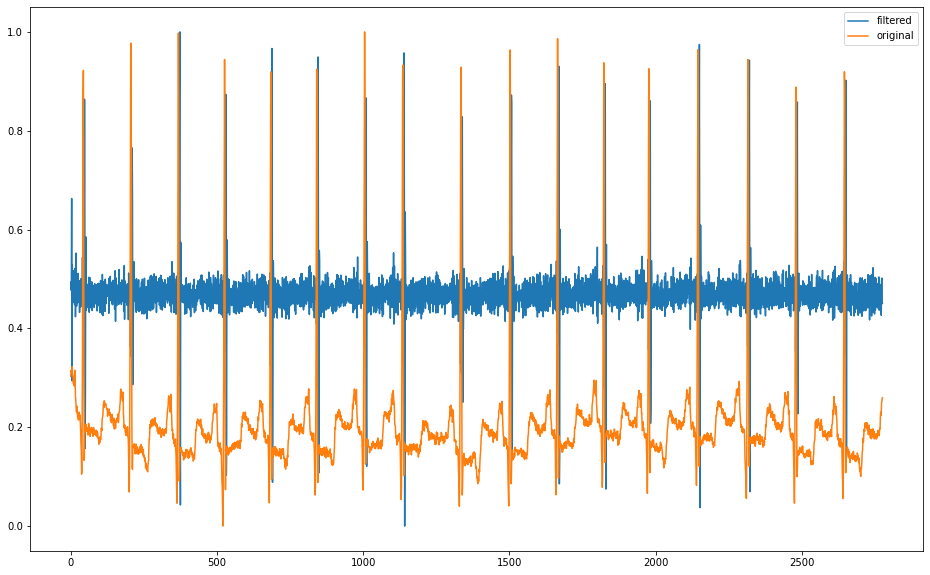

In [18]:
dirpath = 'arrhythmia'
sample = '100'
annotation = wfdb.rdann(f'../data/{dirpath}/{sample}', 'atr', sampfrom=0, sampto=5000)
record = wfdb.rdrecord(f'../data/{dirpath}/{sample}', sampfrom=0, sampto=5000)

# Comparing original and filtered signal
original_resampled, resampled_ann = processing.resample_singlechan(record.p_signal[:, 0], annotation, record.fs, 200)
original_scaled = processing.normalize_bound(original_resampled, lb=0, ub=1)

filtered = filter_signal(original_resampled, [0.5, 50], 200, 9)
filtered = processing.normalize_bound(filtered, lb=0, ub=1)

ax = plt.figure(figsize=(16, 10))
plt.plot(filtered)
plt.plot(original_scaled)

plt.legend(labels=['filtered', 'original'])